## LangGraph
:
LangGraph는 LLM 애플리케이션의 복잡한 워크플로우(Workflow)를 시각적이고 구조적으로 설계할 수 있게 해주는 “그래프 기반 실행 프레임워크”이다. <br>
LLM 호출(Chain, Tool, Retriever, Memory 등)을 노드(Node)로, 데이터 흐름을 엣지(Edge)로 정의하여 AI Agent나 RAG 시스템의 실행 단계를 명확히 구성할 수 있다.

In [1]:
import os
from dotenv import load_dotenv

# .env 파일의 내용 불러오기
load_dotenv("C:/env/.env")

True

In [2]:
# !pip install langgraph

In [3]:
from importlib.metadata import version
print(version("langgraph"))

1.0.1


In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda

# 1) 상태 정의 (TypedDict 사용)
class QAState(TypedDict):
    question: str
    docs: list[str]
    answer: str

# 2) 노드 함수 정의
def retrieve_node(state: QAState) -> QAState:
    state["docs"] = [f"검색된 문서: {state['question']} 관련 내용"]
    return state

def summarize_node(state: QAState) -> QAState:
    docs = "\n".join(state["docs"])
    state["answer"] = f"요약 결과: {docs}"
    return state

# 3) 그래프 구성
graph = StateGraph(QAState)
graph.add_node("retriever", RunnableLambda(retrieve_node))
graph.add_node("summarizer", RunnableLambda(summarize_node))

# 4) 엣지 연결
graph.add_edge("retriever", "summarizer")
graph.set_entry_point("retriever")
graph.set_finish_point("summarizer")

# 5) 그래프 실행
app = graph.compile()
result = app.invoke({"question": "LangGraph란 무엇인가?", "docs": [], "answer": ""})
print(result["answer"])


요약 결과: 검색된 문서: LangGraph란 무엇인가? 관련 내용


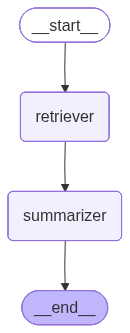

In [5]:
# LangGraph 시각화
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END

# --- 1️⃣ 상태(State) 정의 ---
class AgentState(TypedDict):
    question: str
    tool: str
    result: str
    answer: str


# --- 2️⃣ LLM 초기화 ---
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- 3️⃣ 노드 정의 ---
def decide_tool(state: AgentState) -> AgentState:
    """질문 내용에 따라 어떤 도구를 쓸지 결정"""
    q = state["question"]
    if "계산" in q or "더해" in q:
        state["tool"] = "calculator"
    elif "날씨" in q:
        state["tool"] = "weather"
    else:
        state["tool"] = "llm_direct"
    return state


def tool_node(state: AgentState) -> AgentState:
    """도구 실행"""
    tool = state["tool"]
    q = state["question"]

    if tool == "calculator":
        state["result"] = f"계산 결과: {eval(q.replace('더해', '+'))}"
    elif tool == "weather":
        state["result"] = "오늘 서울의 날씨는 맑고 22도입니다."
    else:
        state["result"] = llm.invoke(f"질문에 답변하세요: {q}").content
    return state


def summarize_node(state: AgentState) -> AgentState:
    """결과를 자연어로 요약"""
    prompt = f"사용자 질문: {state['question']}\n도구 결과: {state['result']}\n이를 바탕으로 자연스럽게 답변하세요."
    response = llm.invoke(prompt)
    state["answer"] = response.content
    return state


# --- 4️⃣ 그래프 구성 ---
graph = StateGraph(AgentState)
graph.add_node("decide_tool", RunnableLambda(decide_tool))
graph.add_node("tool_node", RunnableLambda(tool_node))
graph.add_node("summarize", RunnableLambda(summarize_node))

# --- 5️⃣ 엣지 연결 ---
graph.add_edge("decide_tool", "tool_node")
graph.add_edge("tool_node", "summarize")
graph.set_entry_point("decide_tool")
graph.set_finish_point("summarize")

# --- 6️⃣컴파일 ---
app = graph.compile()

# --- 7️⃣ 테스트 실행 ---
query = "3 더해 7"
result = app.invoke({"question": query, "tool": "", "result": "", "answer": ""})

print("🧾 사용자 질문:", query)
print("⚙️ 선택된 도구:", result["tool"])
print("🧮 도구 결과:", result["result"])
print("💬 최종 답변:", result["answer"])


🧾 사용자 질문: 3 더해 7
⚙️ 선택된 도구: calculator
🧮 도구 결과: 계산 결과: 10
💬 최종 답변: 3에 7을 더하면 10이 됩니다. 다른 질문이 있으시면 언제든지 말씀해 주세요!


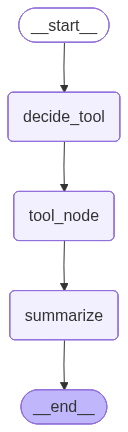

In [7]:
# LangGraph 시각화
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))